In [3]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
# notebook works with jupyter notebook and widget works better with jupyter lab. In case of
# problem with implementation look at the link https://github.com/matplotlib/ipympl



In [1]:
import Aanalysis

ModuleNotFoundError: No module named 'Aanalysis'

In [3]:
print(plt.style.available)
plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Required functions

In [4]:
# Load DSA
def LoadDSA():
    DSA = pd.read_pickle('~/UMCUtrecht/ProcessedData/DSAandDESA/20200505DSA.pickle')
    DSA = DSA.drop([ 'Donor', 'Recipient', 'DonorHLA-RecipientHLA', 'DSA_ABCDRDQ', 'DSA_ABCDRDQ_Status',
       'DSA_ABDRDQ_noPub'], axis=1)
    return DSA

# Load DESA
def LoadDESA(path):
    DESA = pd.read_pickle(path)
    DESA = DESA.drop(['DESA_Epitope', 'EpvsHLA_Pos'], axis=1)
    return  DESA

# Load Suplimentary datasets for adjustments of Kaplan-Meier curves
def LoadKMSup():
    DSA_KM = pd.read_excel('~/UMCUtrecht/KaplanMeier/Kambruva_KM_Suplimentary_Data.xlsx', engine='openpyxl')
    DESA_KM = pd.read_excel('~/UMCUtrecht/KaplanMeier/DESAsurvival.xlsx', engine='openpyxl')
    return DSA_KM, DESA_KM

def scale_age(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    col = ['RecipientAge_NOTR', 'DonorAge_NOTR']
    df[col] = scaler.fit_transform(df[col])
    return df

# DESA setter function needed for the KM Inverse Probability Weighting
def desa_num_setter(DESA_Merged):
    ind_0 = DESA_Merged['#DESA'] == 0
    ind_12 = (DESA_Merged['#DESA'] > 0) & (DESA_Merged['#DESA'] <= 2)
    ind_3orMore = DESA_Merged['#DESA'] >= 3
    DESA_Merged.loc[ind_0, 'noDESA'] = 1
    DESA_Merged.loc[ind_12, 'DESA_12'] = 1
    DESA_Merged.loc[ind_3orMore, 'DESA_3orMore'] = 1
    DESA_Merged[['noDESA', 'DESA_12', 'DESA_3orMore']] = DESA_Merged[['noDESA', 'DESA_12', 'DESA_3orMore']].fillna(0)
    return DESA_Merged

# DESA setter function needed for the KM Inverse Probability Weighting
def ipw(DESA_Merged):

    import statsmodels.api as sm # import stastmodels
    import statsmodels.formula.api as smf # this allows us to use an explicit formulation like in R
     
    DESA_Merged = scale_age(DESA_Merged)
    # estimate propensity scores and calculate weights
    model1 = smf.glm('noDESA ~ RecipientAge_NOTR +  RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + \
                    DonorAge_NOTR*DonorAge_NOTR +  CIPHour_DBD + CIPHour_DCD + IL2rMoAb', data=DESA_Merged, family=sm.families.Binomial())
    model2 = smf.glm('DESA_12 ~ RecipientAge_NOTR +  RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + \
                    DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb', data=DESA_Merged, family=sm.families.Binomial())
    model3 = smf.glm('DESA_3orMore ~ RecipientAge_NOTR +  RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + \
                    DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb', data=DESA_Merged, family=sm.families.Binomial())
    result1, result2, result3 = model1.fit(), model2.fit(), model3.fit()
    print(result1.summary())
    print(result2.summary())
    print(result3.summary())
    pr1raw = result1.fittedvalues
    pr2raw = result2.fittedvalues
    pr3raw = result3.fittedvalues
    # Find propensity scores 
    pr1 = pr1raw/(pr1raw + pr2raw + pr3raw)
    pr2 = pr2raw/(pr1raw + pr2raw + pr3raw)
    pr3 = pr3raw/(pr1raw + pr2raw + pr3raw)

    # Calculate the weights
    DESA_Merged['w'] = (DESA_Merged.noDESA==1) * (1/pr1) + (DESA_Merged.DESA_12==1) * (1/pr2) + (DESA_Merged.DESA_3orMore==1) * (1/pr3)
#     DESA_Merged['w'] =1
  # adjusted Kaplan-Meier estimator by IPW
    #Pr0 <- glm(NoDESA~ 1, family = binomial(link="logit"), data=failureData)$fitted.values[1]
    # glmfit1 <- glm(noDESA ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb, family=binomial(link = "logit"), na.action = na.omit)
    # glmfit2 <- glm(DESA_12        ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb, family=binomial(link = "logit"), na.action = na.omit)
    # glmfit3 <- glm(DESA_3orMore   ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTR + IL2rMoAb, family=binomial(link = "logit"), na.action = na.omit)
    # Pr1raw <- glmfit1$fitted.values
    # Pr2raw <- glmfit2$fitted.values
    # Pr3raw <- glmfit3$fitted.values
    # print(length(Pr1raw) - sum(Pr1raw + Pr2raw + Pr3raw))
    # sum123raw <- Pr1raw+Pr2raw+Pr3raw
    # Pr1 <- Pr1raw / sum123raw 
    # Pr2 <- Pr2raw / sum123raw 
    # Pr3 <- Pr3raw / sum123raw 
    # print(Pr1 - Pr1raw)

    # W <- (groupCode=="noDESA") * (1/Pr1) + (groupCode=="DESA_12") * (1)/(Pr2) + (groupCode=="DESA_3orMore") * (1)/(Pr3) 
    return DESA_Merged


def plot_KM(DESA_Merged:pd.DataFrame, Title:str, save_as:str, split, cutofDESA=2, *args, **kwargs):
    
    # Create and set noDESA, DESA_12, and DESA_3ormore columns
    DESA_Merged = desa_num_setter(DESA_Merged)
    
    # findind the inverse probability weights
    DESA_Merged = ipw(DESA_Merged)

    # Sketch the Kaplan Meier Curves
    
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    kmf3 = KaplanMeierFitter()


    ind_dead = DESA_Merged.TypeOfDonor_NOTR == 'Deceased'
    ind_desa = DESA_Merged.Status == 'DESA'
    if split == '#DESA':
        label_1, ind_split_1 = f'#DESA<={cutofDESA}', DESA_Merged['#DESA'].apply(lambda x: x <= cutofDESA)
        label_2, ind_split_2 = f'#DESA>{cutofDESA}', ~ind_split_1
    if split == 'Odd/Even':
        label_1, ind_split_1 = 'Even #DESA', DESA_Merged['#DESA'].apply(lambda x: x % 2 == 0) # Even
        label_2, ind_split_2 = 'Odd #DESA', ~ind_split_1
        
    ind_T1 = ~ind_desa & ind_dead
    ind_T2 = ind_desa & ind_split_1 & ind_dead
    ind_T3 = ind_desa & ind_split_2 & ind_dead

    T1 = DESA_Merged.loc[ind_T1,'GraftSurvival10Y_R']
    T2 = DESA_Merged.loc[ind_T2,'GraftSurvival10Y_R']
    T3 = DESA_Merged.loc[ind_T3,'GraftSurvival10Y_R']


    E1 = DESA_Merged.loc[ind_T1,'FailureCode10Y_R']   # lifeline automatically ignores the 2's in the FailureCode_NOTR column
    E2 = DESA_Merged.loc[ind_T2,'FailureCode10Y_R']    # and only consideres the 1's. This means 2's are considered as 0, as well.
    E3 = DESA_Merged.loc[ind_T3,'FailureCode10Y_R']

    fig, ax = plt.subplots(figsize=(8, 7))

    t = np.linspace(0, 10, 1000)                               # This indicates the timeline that we would like to sketch the Kaplan Meier curve. 
    kmf1.fit(T1, event_observed=E1, timeline=t, weights=DESA_Merged[ind_T1]['w'], label='No DESA')   # the alpha value in the confidence intervals
    kmf1.plot(ci_show=False, ax=ax, color='black', *args, **kwargs)

    kmf2.fit(T2, event_observed=E2, timeline=t, weights=DESA_Merged[ind_T2]['w'], label=label_1)
    kmf2.plot(ci_show=False, ax=ax, color='blue', *args, **kwargs)

    kmf3.fit(T3, event_observed=E3, timeline=t,  weights=DESA_Merged[ind_T3]['w'], label=label_2)
    kmf3.plot(ci_show=False, ax=ax, color='red', *args, **kwargs)
    Num=ind_dead.sum()
    ax.set_title(f'{Title}, Deceased Donor (N={Num})', fontsize=20)
    ax.set_xlabel('Years after Tranplantation', fontsize=20)
    ax.set_ylabel('Graft Survival (%)', fontsize=20)
    ax.legend(prop={"size":15})
    ax.set_ylim(0.2)
    plt.tight_layout()
    add_at_risk_counts(kmf1, kmf2, kmf3, ax=ax, fontsize=15);
    plt.show()
    if save_as != 0:
        fname = save_as
        fig.savefig(f'./Figures/{fname}.pdf')
    # Final values
    km1_final = kmf1.survival_function_.values[-1][0]*100
    km2_final = kmf2.survival_function_.values[-1][0]*100
    km3_final = kmf3.survival_function_.values[-1][0]*100
    print(f'Top KM curve: {km1_final:.2f}, Middle KM curve: {km2_final: .2f}')
    print(f'10-Year Gap is: {km1_final - km3_final : .2f}')
    km1_final = kmf1.survival_function_.values[100][0]*100
    km3_final = kmf3.survival_function_.values[100][0]*100
    print(f'1-Year Gap is: {km1_final - km3_final : .2f}')
    
# plot_KM(DESA_old_All_Merged, 'DESA_old_All')

# Load Dataset

In [54]:
DSA = LoadDSA()
DSA_KM, DESA_KM = LoadKMSup()

In [55]:
# Some Scripts to compare the centers success rates
# DESA_KM.groupby('Center')['GraftSurvival10Y_R'].describe()
# DESA_KM.groupby('Center')['GraftSurvival10Y_R'].apply(lambda x: (x>=10).sum()/len(x) ).sort_values(ascending=False)
# DESA_KM.groupby('Center')['GraftSurvival10Y_R'].count().sort_values(ascending=False)

# ALL Epitopes

Index(['TransplantID', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m', 'Status',
       '#DESA'],
      dtype='object')
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 noDESA   No. Observations:                 4690
Model:                            GLM   Df Residuals:                     4684
Model Family:                Binomial   Df Model:                            5
Link Func

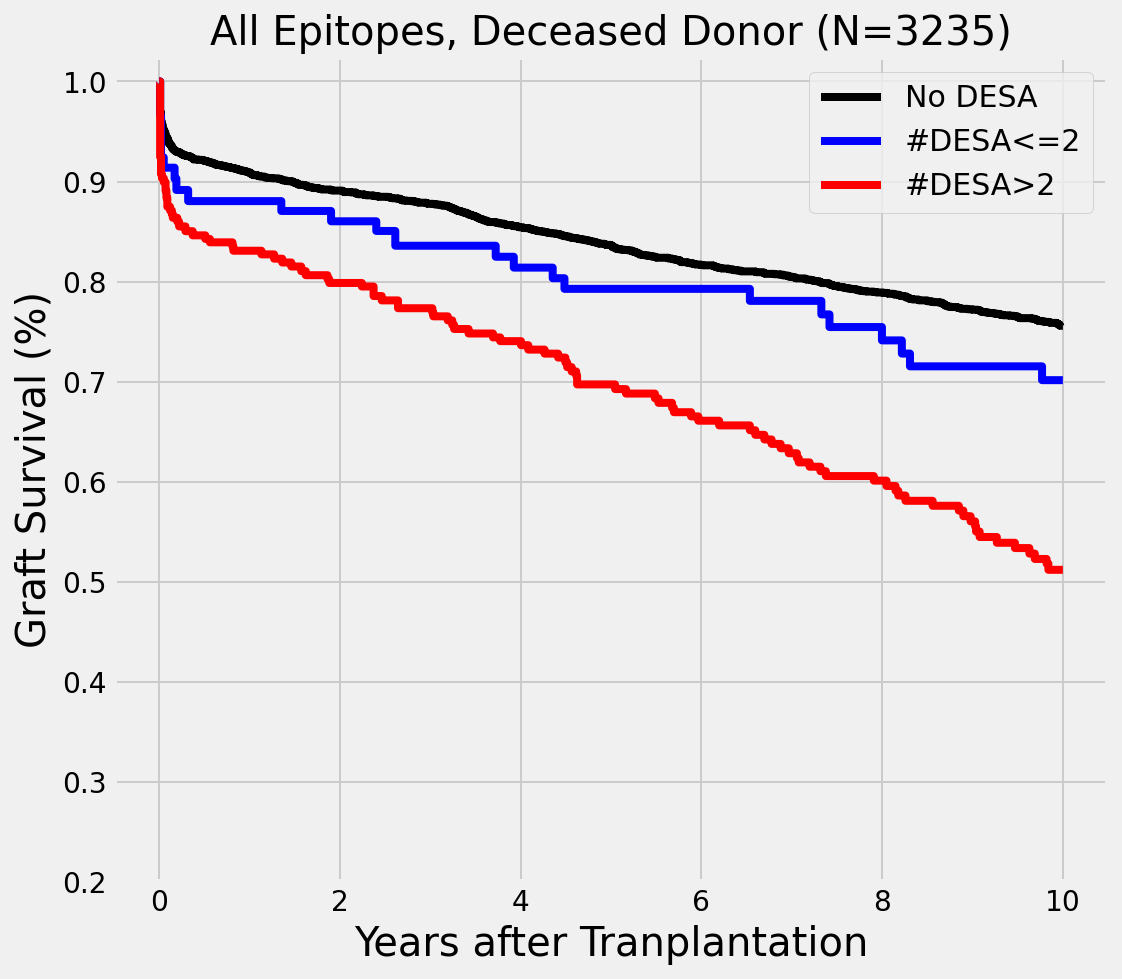

Top KM curve: 75.58, Middle KM curve:  70.14
10-Year Gap is:  24.40
1-Year Gap is:  7.77


In [56]:
# %%time
path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200511_DESA_old_All.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
print(DESA_Merged.columns)
plot_KM(DESA_Merged, 'All Epitopes', split='#DESA', save_as='')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 noDESA   No. Observations:                 4690
Model:                            GLM   Df Residuals:                     4684
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1451.2
Date:                Wed, 09 Jun 2021   Deviance:                       2902.3
Time:                        15:25:05   Pearson chi2:                 4.69e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.4197      0.22

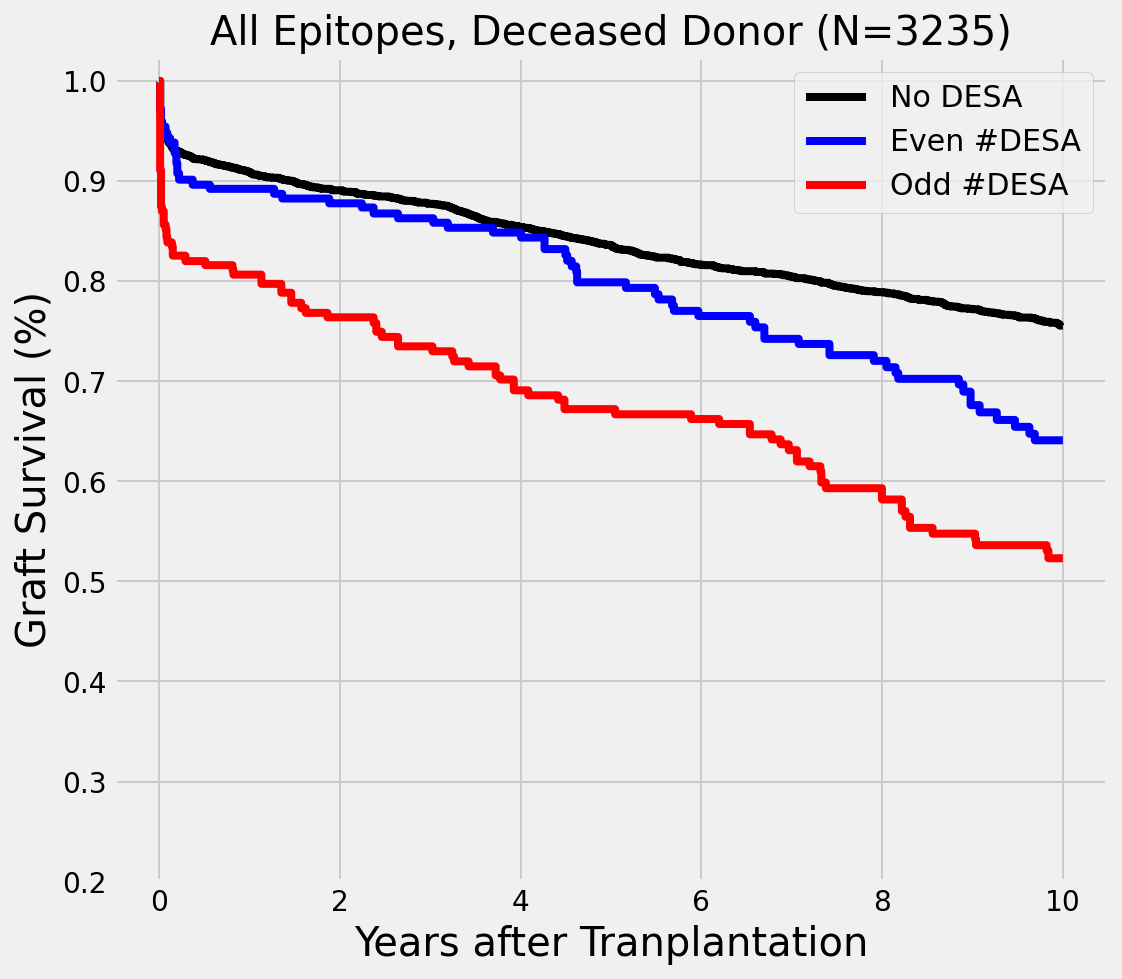

Top KM curve: 75.55, Middle KM curve:  64.09
10-Year Gap is:  23.24
1-Year Gap is:  10.21


In [57]:
path = '/Users/Danial/UMCUtrecht/ProcessedData/DSAandDESA/20200916_DESA_new_All.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, Title='All Epitopes',  split='Odd/Even', save_as='')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 noDESA   No. Observations:                 4690
Model:                            GLM   Df Residuals:                     4684
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1451.2
Date:                Wed, 09 Jun 2021   Deviance:                       2902.3
Time:                        15:25:05   Pearson chi2:                 4.69e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.4197      0.22

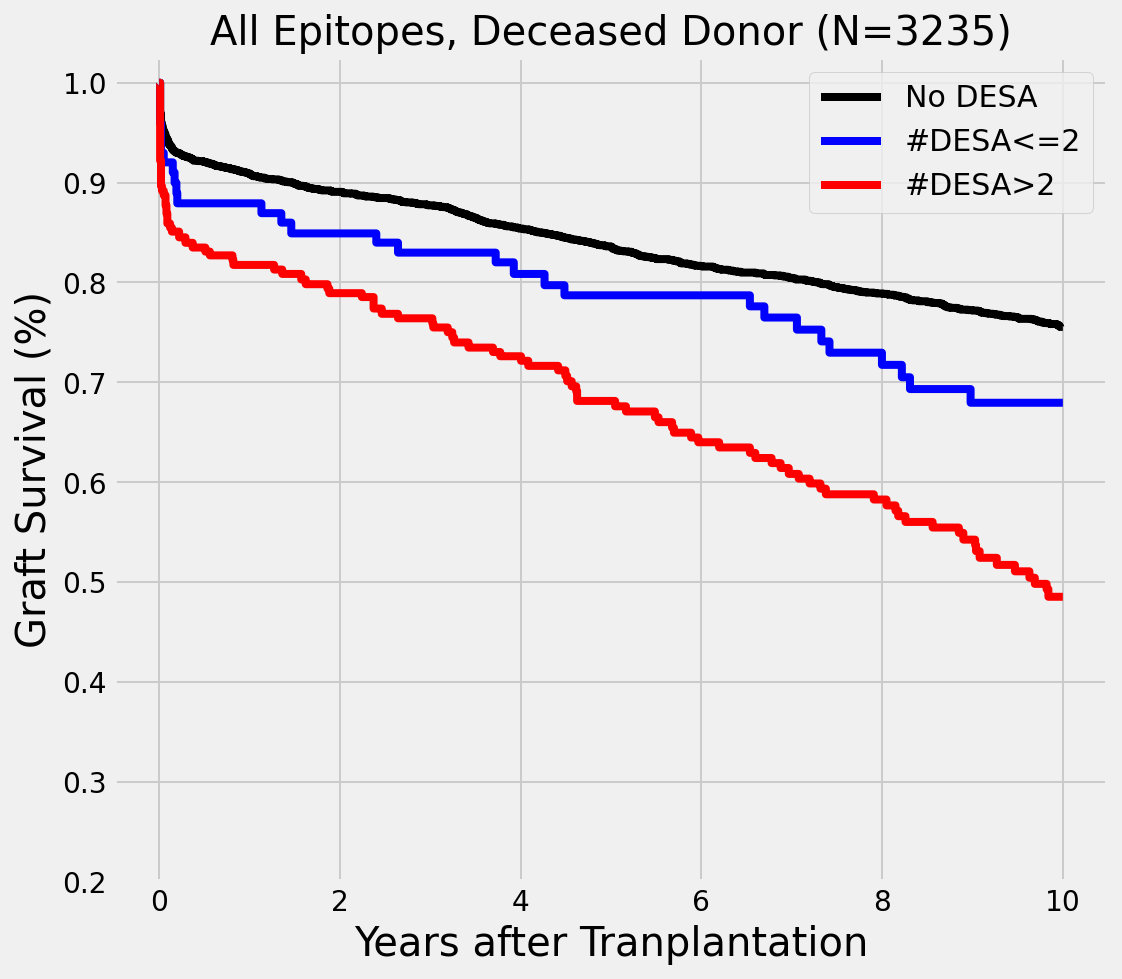

Top KM curve: 75.55, Middle KM curve:  67.95
10-Year Gap is:  27.03
1-Year Gap is:  9.10


In [58]:
path = '/Users/Danial/UMCUtrecht/ProcessedData/DSAandDESA/20200916_DESA_new_All.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, Title='All Epitopes',  split='#DESA', save_as='')

## Below we see that the column 'GraftSurvivalYears_NOTR' is equal to the result of below calculations. 

Thus, we will not include a new column in the data frame and will just use 'DateGraftFailure_NOTR' column


In [59]:
# ixE0 = KM_DataFrame['E']== 0
# KM_DataFrame.loc[ixE0,'Duration'] = KM_DataFrame.loc[ixE0,'DateLastSeen_NOTR'] - KM_DataFrame.loc[ixE0,'TransplantDate_NOTR']
# KM_DataFrame.loc[~ixE0,'Duration'] = KM_DataFrame.loc[~ixE0,'DateGraftFailure_NOTR'] - KM_DataFrame.loc[~ixE0,'TransplantDate_NOTR']
# # KM_DataFrame['Duration'].dt.components # This gives all the time components in time delta objet.
# KM_DataFrame['Duration'] = KM_DataFrame['Duration'].dt.days/365 # Duration is based on day and now is changed to year look at components method for more details
# KM_DataFrame

# Inverse Probability Weight

As implied by its name, inverse probability weighting literally refers to weighting the outcome measures by the inverse of the probability of the individual with a given set of covariates being assigned to their treatment (note that this doesn’t depend on whether or not the individual was in fact assigned to treatment). This quantity is known as the propensity score and is denoted by

$$p(x)=P(T=1|X=x)$$

In our case we have to change the treatment group to transplants having DSA/DESA group. Inverse probability weighting literally refers to weighting the outcome measures by the inverse of the probability of the Transplants with a given set of covariates being assigned to the having DSA group (note that this doesn’t depend on whether or not the Transplant actually has DSA/DESA). This quantity is known as the propensity score and is denoted by

$$p(x)=P(Tx\, \in DSA/DESA|X=x)$$


In [49]:
# R codes to generate the probability of each trasnplant belonging to the DSA group.

# glmfit1 <- glm(DSA ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTR + LivingDonorNum + CIPHour_DBD + CIPHour_DCD + IL2rMoAb, family=binomial(link = "logit"), na.action = na.omit)
# Pr1 <- glmfit1$fitted.values
# Pr0 <- 1- Pr1 
# W <- (groupCode==0) * (1/Pr0) + (groupCode==1) * (1)/(Pr1)

# Kaplan Meier Curve for DSA

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    DSA   No. Observations:                 4724
Model:                            GLM   Df Residuals:                     4717
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1710.9
Date:                Wed, 09 Jun 2021   Deviance:                       3421.8
Time:                        15:24:50   Pearson chi2:                 4.72e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.9845      0.24

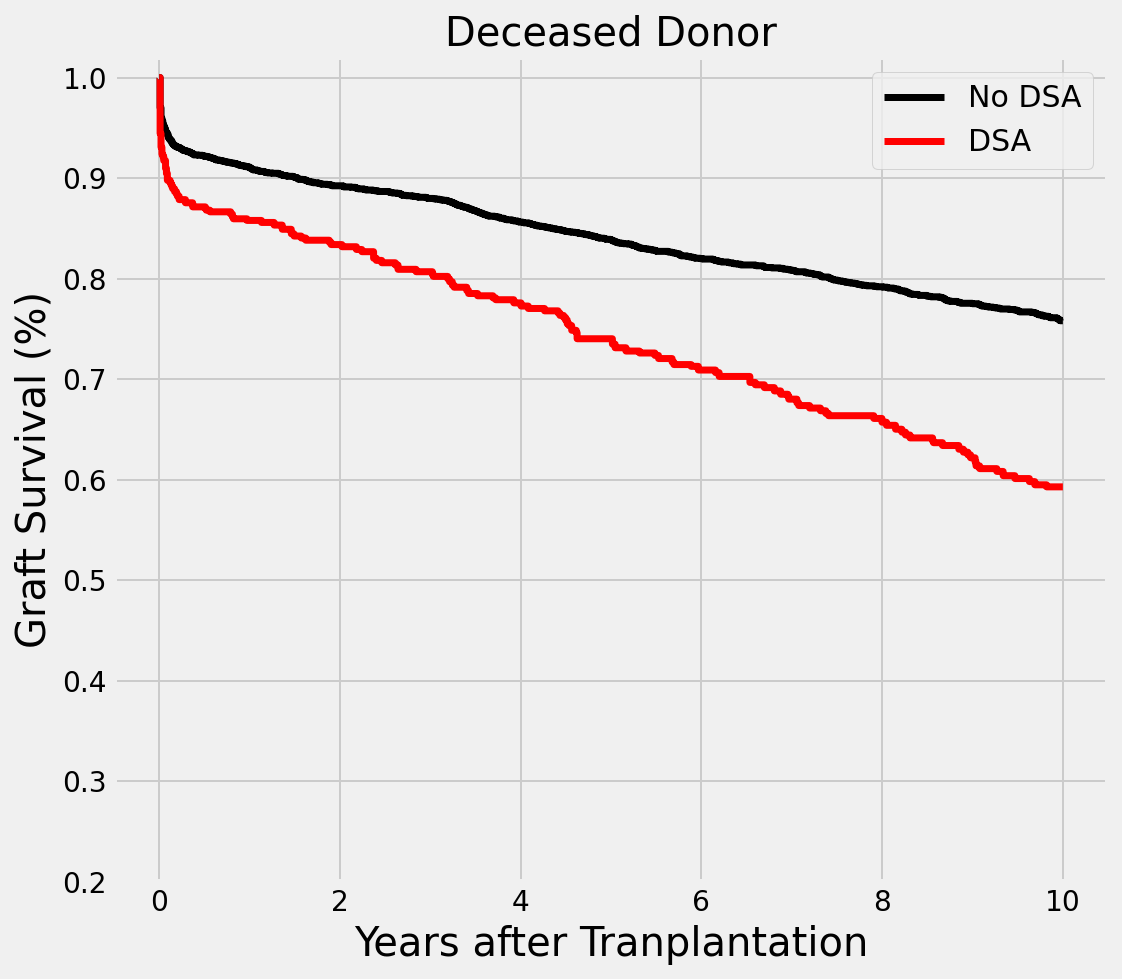

In [52]:
DSA_Merged = DSA_KM.merge(DSA, on='TransplantID')

#-----------------------------------
# estimate propensity scores and calculate weights
#----------------------------------

import statsmodels.api as sm # import stastmodels
import statsmodels.formula.api as smf # this allows us to use an explicit formulation
 
DSA_Merged = scale_age(DSA_Merged)

model = smf.glm('DSA ~ RecipientAge_NOTR +  RecipientAge_NOTR*RecipientAge_NOTR +\
    DonorAge_NOTR + LivingDonorNum +  DonorAge_NOTR*DonorAge_NOTR +\
    CIPHour_DBD + CIPHour_DCD + IL2rMoAb', data=DSA_Merged, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

# add propensity scores 
DSA_Merged['ps'] =  result.fittedvalues
DSA_Merged['w'] = np.where(DSA_Merged.DSA_ABDRDQ_noPub_Status=='DSA', 1/DSA_Merged.ps ,1/(1-DSA_Merged.ps))

# Define Kaplan Meier Fitter Instance

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()


ind_dead = DSA_Merged.TypeOfDonor_NOTR == 'Deceased'
ind_dsa = DSA_Merged.DSA_ABDRDQ_noPub_Status == 'DSA'

ind_T1 = ~ind_dsa & ind_dead
ind_T2 = ind_dsa & ind_dead
T1 = DSA_Merged.loc[ind_T1,'GraftSurvival10Y_R']
T2 = DSA_Merged.loc[ind_T2,'GraftSurvival10Y_R']


E1 = DSA_Merged.loc[ind_T1,'FailureCode10Y_R']   # lifeline automatically ignores the 2's in the FailureCode_NOTR column
E2 = DSA_Merged.loc[ind_T2,'FailureCode10Y_R']    # and only consideres the 1's. This means 2's are considered as 0, as well.

fig, ax = plt.subplots(figsize=(8,7))

t = np.linspace(0, 10, 1000)                               # This indicates the timeline that we would like to sketch the Kaplan Meier curve. 
kmf1.fit(T1, event_observed=E1, timeline=t, weights=DSA_Merged[ind_T1]['w'], label='No DSA')   # the alpha value in the confidence intervals
kmf1.plot(ci_show=False, ax=ax, lw=3.5, color='black')

kmf2.fit(T2, event_observed=E2, timeline=t, weights=DSA_Merged[ind_T2]['w'], label='DSA')
kmf2.plot(ci_show=False, ax=ax, lw=3.5, color='red')

# kmf3.fit(T2, event_observed=E2, timeline=t, label='DSA[No weight]')
# kmf3.plot(ci_show=False, ax=ax, lw=1.5, linestyle='--', color='red')

N = ind_dead.sum()
# ax.set_title(f'Deceased Donor (N={N})', fontsize=20)
ax.set_title(f'Deceased Donor', fontsize=20)
ax.set_xlabel('Years after Tranplantation', fontsize=20)
ax.set_ylabel('Graft Survival (%)', fontsize=20)
ax.legend(prop={"size":15})
ax.set_ylim(0.2)
# kmf2.fit(data.loc[~inx,'Duration'] , event_observed=data.loc[~inx,'E'], timeline=t, label='<10')   # the alpha value in the confidence intervals
# kmf2.plot(ci_show=False, ax=ax)
plt.tight_layout()

# add_at_risk_counts(kmf1, kmf2, ax=ax);
plt.savefig('./Figures/DSA.pdf')

Kaplan Meier Curve for DESA with old Epitope vs HLA Database
==========================================================


In [36]:
path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200511_DESA_old_Exposed.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, 'Exposed Ep', save_as='DESA_old_Exposed')

TypeError: plot_KM() missing 1 required positional argument: 'split'

Kaplan Meier Curve for DESA with new Epitope vs HLA Database
==========================================================

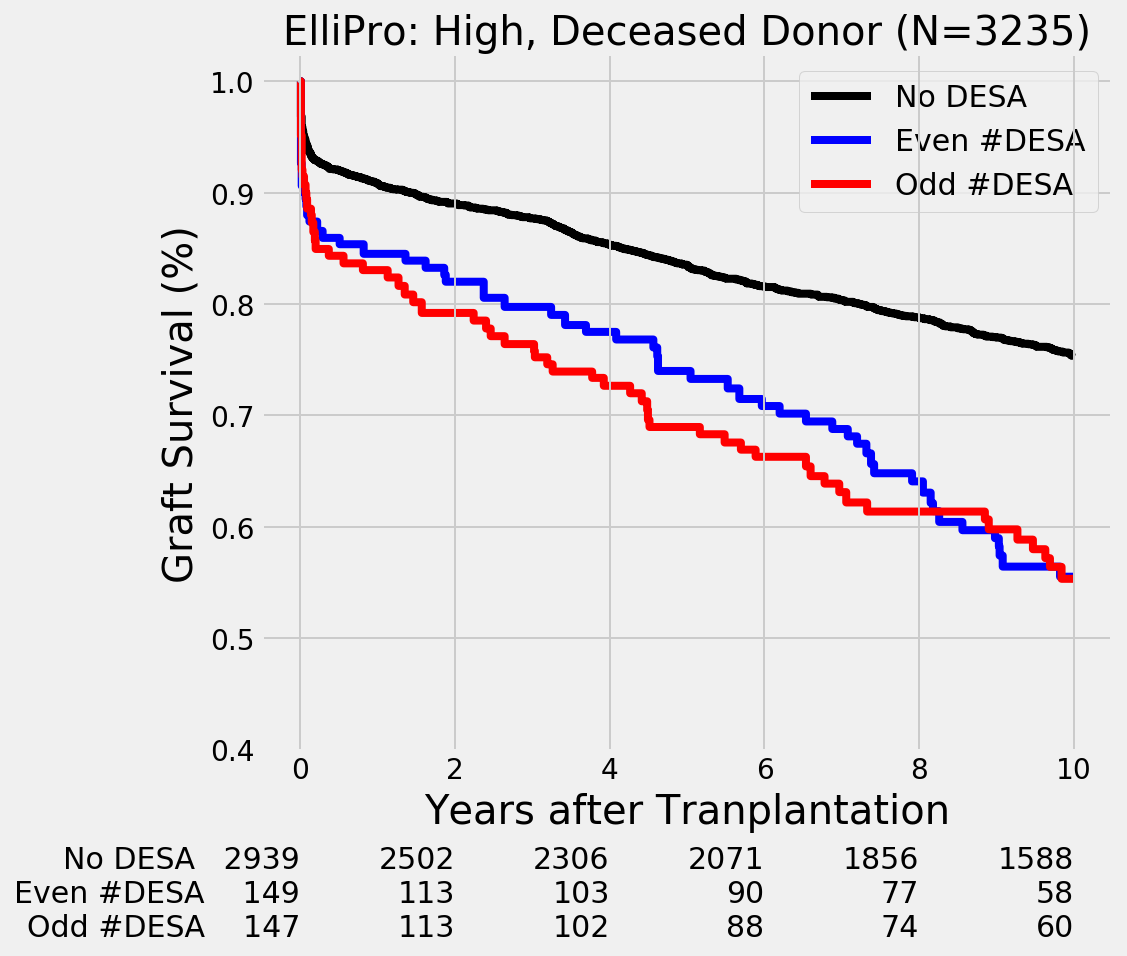

Top KM curve: 75.35, Middle KM curve:  55.50
10-Year Gap is:  20.04
1-Year Gap is:  7.75


In [44]:
path = '/Users/Danial/UMCUtrecht/ProcessedData/DSAandDESA/20200916_DESA_new_H.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, 'ElliPro: High', split='Odd/Even', save_as='DESA_H')

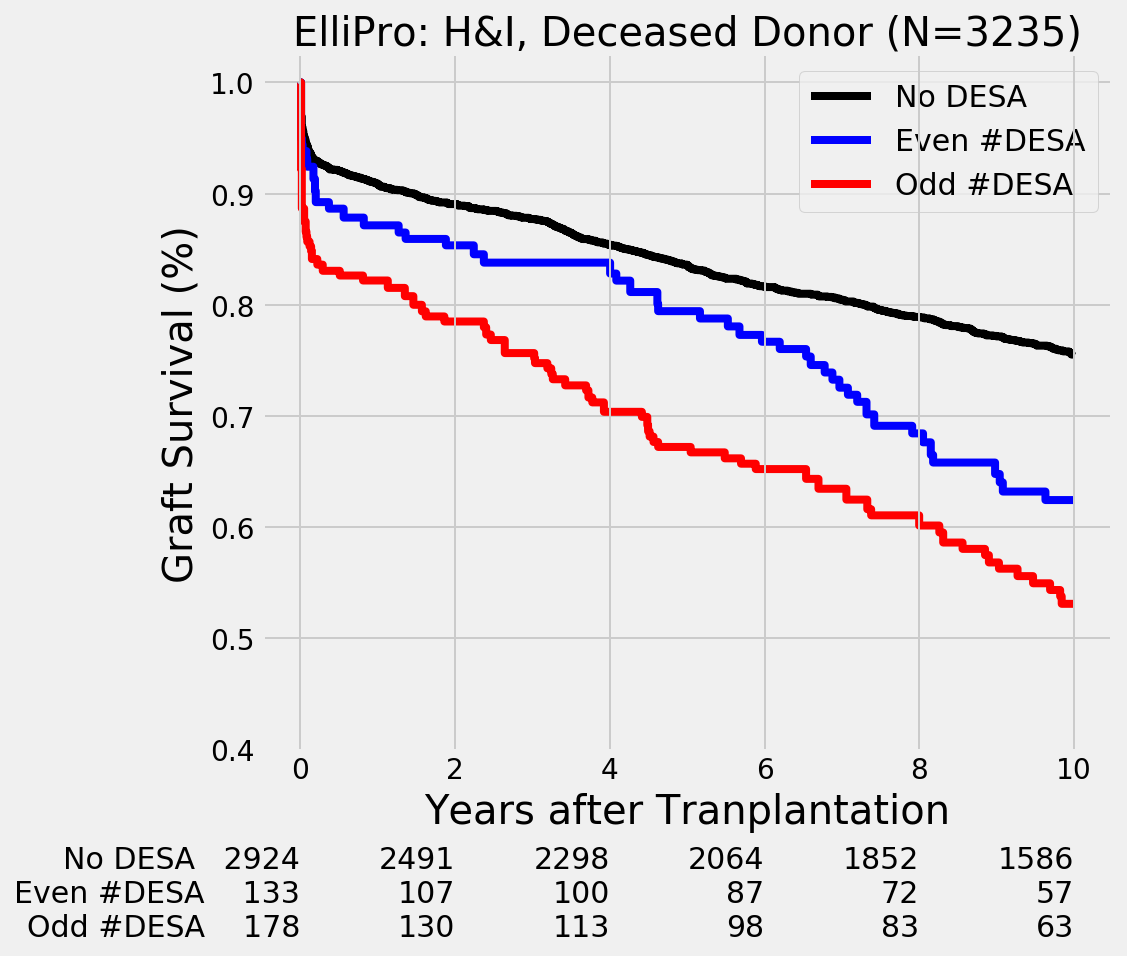

Top KM curve: 75.52, Middle KM curve:  62.43
10-Year Gap is:  22.43
1-Year Gap is:  8.66


In [42]:
path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200916_DESA_new_HI.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, 'ElliPro: H&I', split='Odd/Even', save_as='DESA_HI')

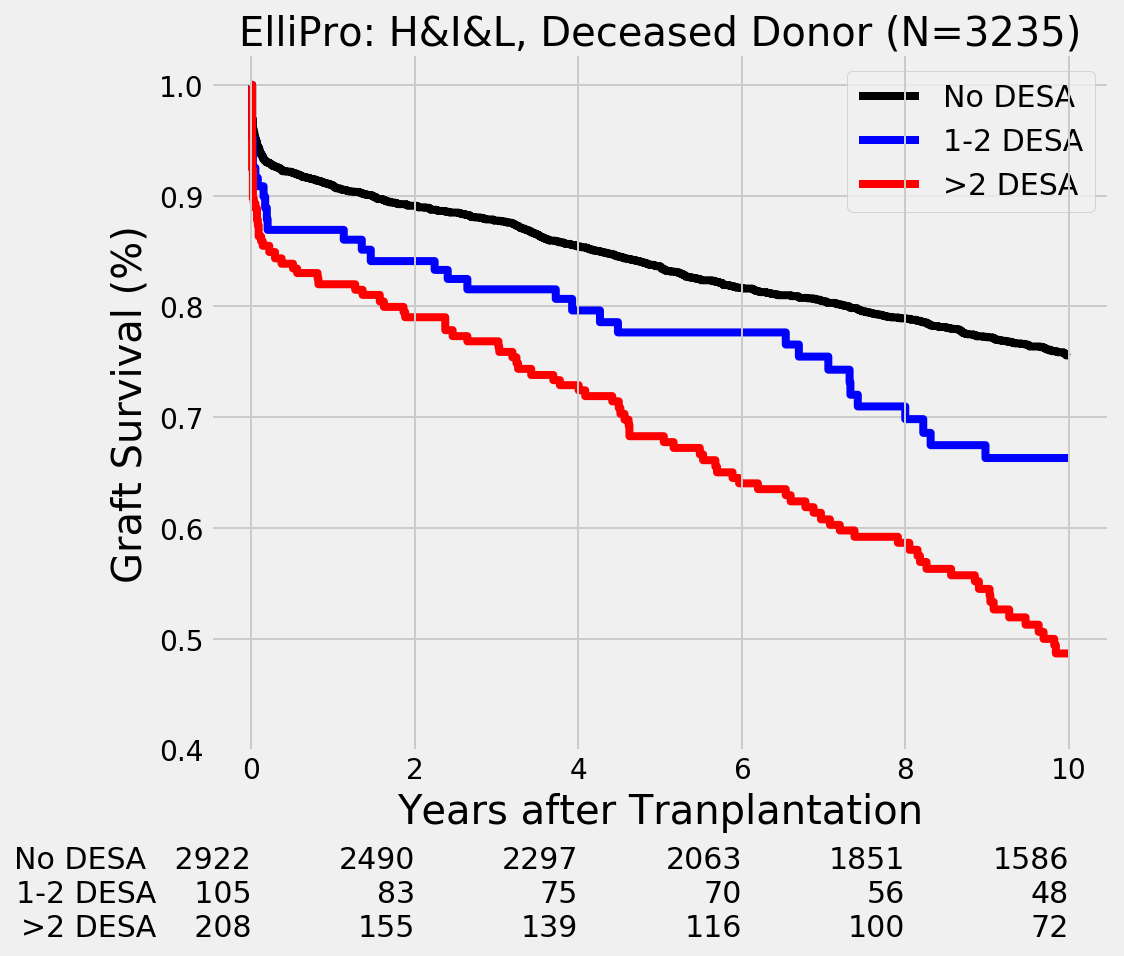

Top KM curve: 75.57, Middle KM curve:  66.30
10-Year Gap is:  26.91
1-Year Gap is:  8.87


In [32]:
path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200804_DESA_new_HIL.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, 'ElliPro: H&I&L', 'DESA_HIL')

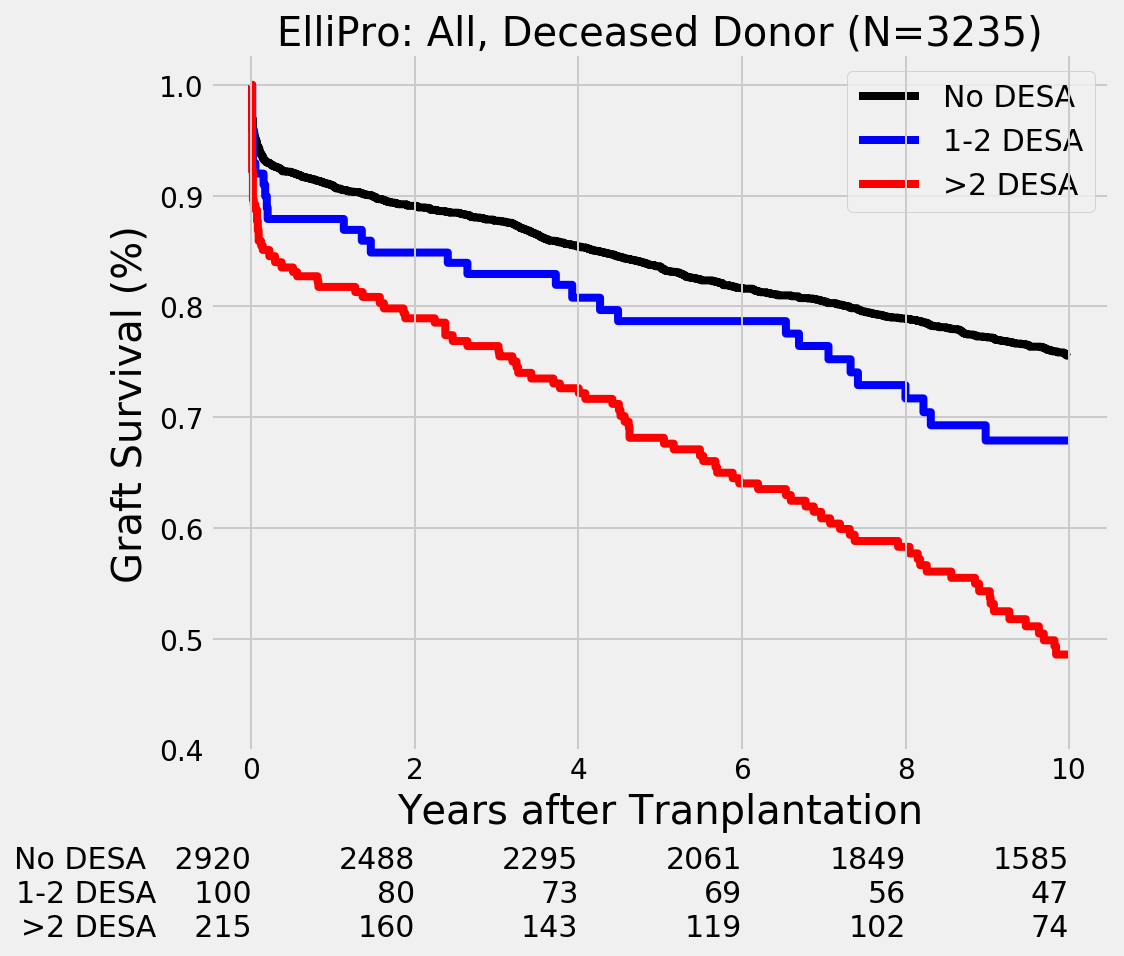

Top KM curve: 75.55, Middle KM curve:  67.89
10-Year Gap is:  26.99
1-Year Gap is:  9.10


In [37]:
path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200804_DESA_new_All.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, 'ElliPro: All', save_as='DESA_new_All')

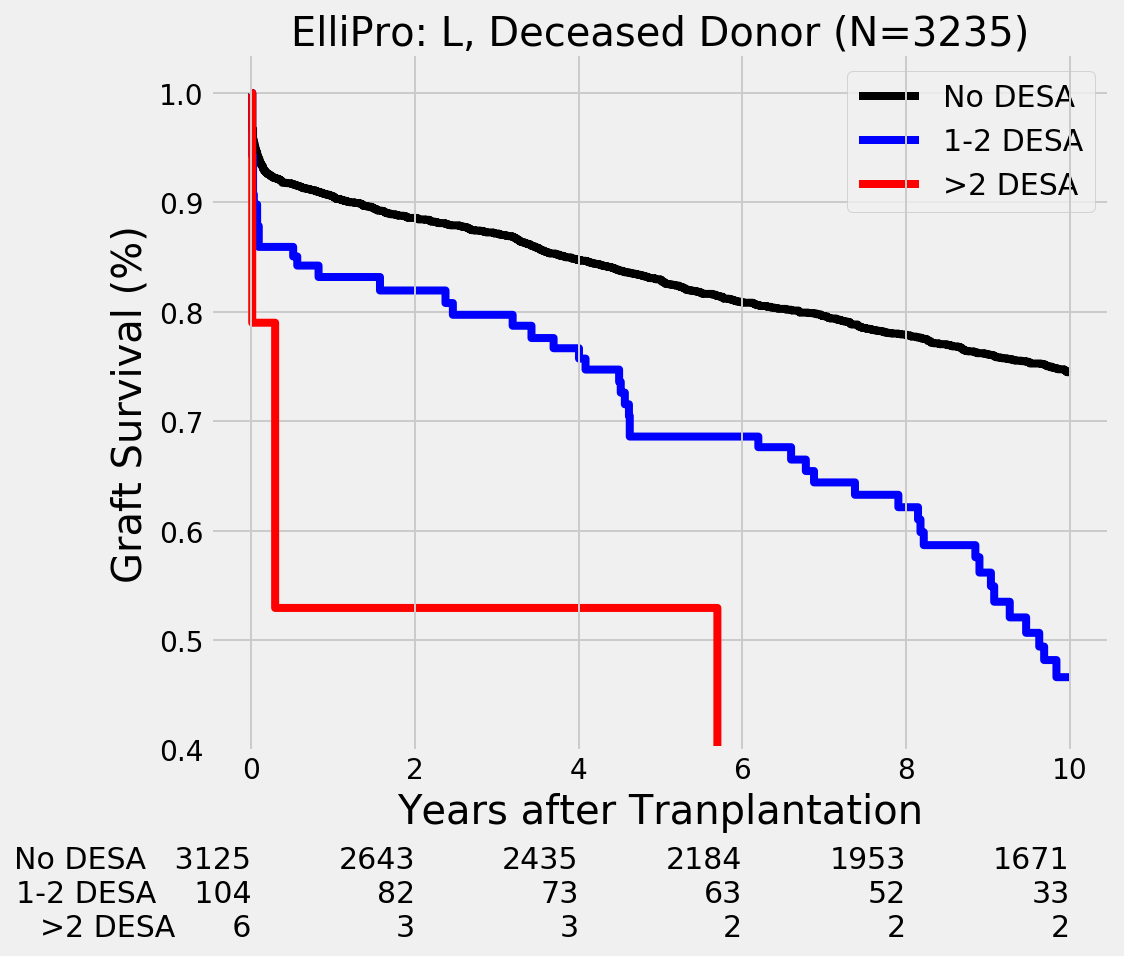

Top KM curve: 74.47, Middle KM curve:  46.60
10-Year Gap is:  41.31
1-Year Gap is:  37.58


In [34]:
path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200804_DESA_new_L.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, 'ElliPro: L', 'DESA_L')

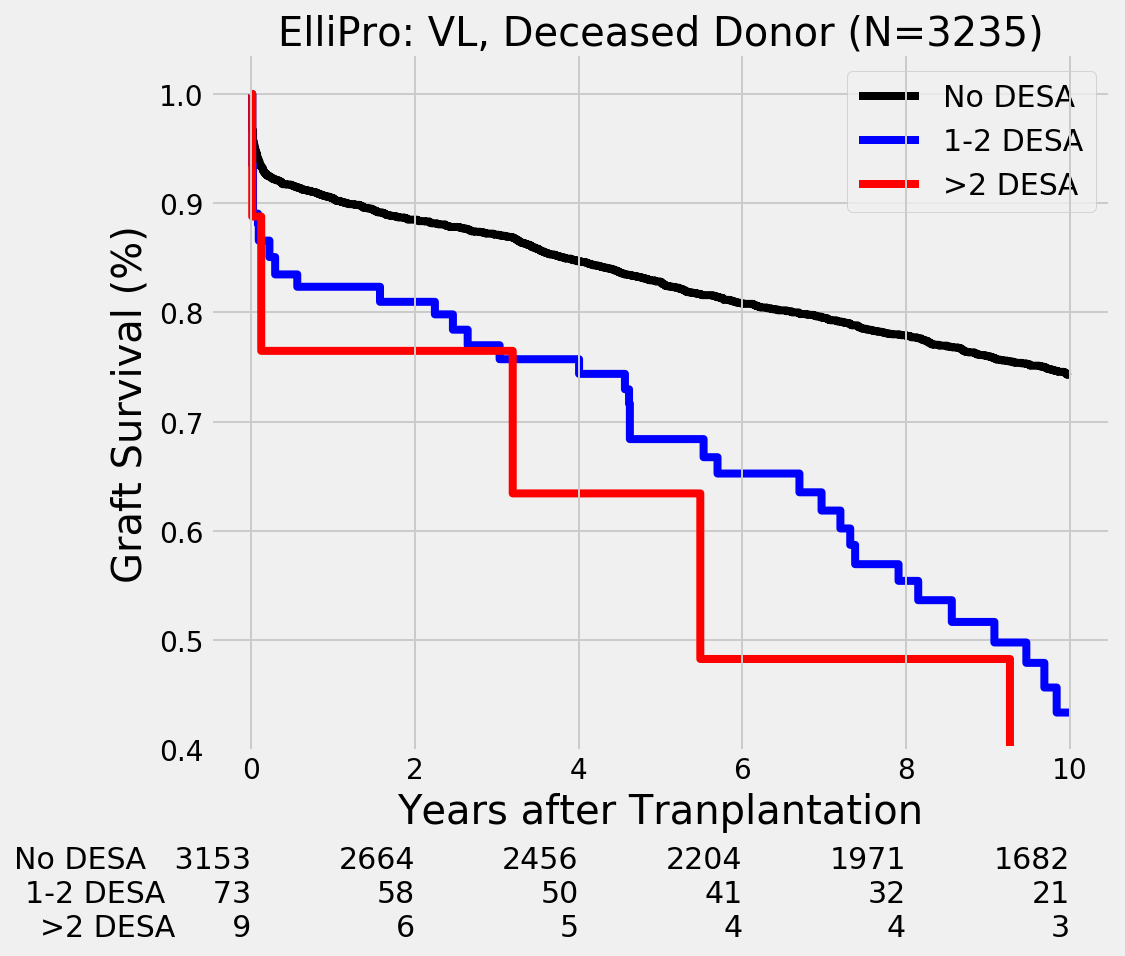

Top KM curve: 74.29, Middle KM curve:  43.37
10-Year Gap is:  43.12
1-Year Gap is:  13.92


In [45]:
path = '~/UMCUtrecht/ProcessedData/DSAandDESA/20200804_DESA_new_VL.pickle'
DESA = LoadDESA(path)
DESA_Merged = DESA_KM.merge(DESA, on='TransplantID')
plot_KM(DESA_Merged, 'ElliPro: VL', 'DESA_VL')

In [ ]:
%lsmagic

# Kaplan Meier plot with Plotly

In [ ]:
def pyplot_KM(fig, ci=True, legend=True):
    # Convert mpl fig obj to plotly fig obj, resize to plotly's default
    py_fig = tls.mpl_to_plotly(fig, resize=True)
    
    # Add fill property to lower limit line
    if ci == True:
        style1 = dict(fill='tonexty')
        # apply style
        py_fig['data'][2].update(style1)
        
        # Change color scheme to black
        py_fig['data'].update(dict(line=Line(color='black')))
    
    # change the default line type to 'step'
    py_fig['data'].update(dict(line=Line(shape='hv')))
    # Delete misplaced legend annotations 
    py_fig['layout'].pop('annotations', None)
    
    if legend == True:
        # Add legend, place it at the top right corner of the plot
        py_fig['layout'].update(
            showlegend=True,
            legend=Legend(
                x=1.05,
                y=1
            )
        )
        
    # Send updated figure object to Plotly, show result in notebook
    return py.iplot(py_fig)


